# PPO on Atari games using Custom CNN

This notebook will explore the implementation of PPO from Stable Baseline3 using a Custom CNN feature extractor on Atari Environment.

### What you will learn?
* Using PPO from Stable Baseline3 Using Custom CNN
* Training on Breakout Environment

## Setup
Install necessary dependencies.

In [1]:
# Installing the necessary packages for Atari environments
!pip install gymnasium
!pip install gymnasium[atari]
!pip install ale-py

In [2]:
# Installing necessary packages for visualization and virtual display
!sudo apt-get update
!sudo apt-get install -y cmake
# Updating the package list and installing ffmpeg and freeglut3-dev for visualization, xvfb for virtual display
!sudo apt-get install -y ffmpeg freeglut3-dev xvfb

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease                         
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease               
Hit:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
cmake is already the newest version (3.22.1-1ubuntu1.22.04.2).
0 upgraded, 0 newly installed, 0 to remove and 27 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
freeglut3-dev is already the newest version (2.8.1-6).
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.15).
0 upgraded, 0 newly installed, 0 to remove and 27 not upgraded.


In [3]:
# Installing Stable Baselines3 with extra dependencies
!pip install "stable-baselines3[extra]"
!pip install moviepy

In [4]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # suppress TF INFO/WARN/ERROR

Import libraries

In [5]:
# Import necessary libraries and modules
import gymnasium as gym
import stable_baselines3
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torch
from pathlib import Path
import base64
from IPython import display as ipythondisplay

# Import utility functions for creating Atari environments and stacking frames
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack

print(f"{gym.__version__=}")
print(f"{stable_baselines3.__version__=}")

E0000 00:00:1760405985.760907    4632 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760405985.766537    4632 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


gym.__version__='1.2.1'
stable_baselines3.__version__='2.7.0'


Configure Environment

In [6]:
# Set up a fake display for rendering videos in the cloud environment
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'

## Callbacks and directory setup

In [7]:
# Callback for saving the model at regular intervals
class SaveOnIntervalCallback(BaseCallback):
    def __init__(self, save_interval: int, save_path: str, verbose=1):
        super().__init__(verbose)
        self.save_interval = save_interval
        self.save_path = save_path

    def _on_step(self) -> bool:
        if self.num_timesteps % self.save_interval == 0:
            save_file = os.path.join(self.save_path, f'model_{self.num_timesteps}')
            self.model.save(save_file)
            if self.verbose > 0:
                print(f'Saving model to {save_file}.zip')
        return True

In [8]:
# Creating directories for storing logs and models
log_dir = "ppo/logs/"
models_dir = "ppo/models/"

os.makedirs(log_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)

## Define Custom Feature Extractor and Create DQN Model

In [9]:
# Custom CNN Feature Extractor
class CustomCNN(BaseFeaturesExtractor):
    def __init__(self, observation_space: gym.spaces.Box, features_dim: int = 512):
        super(CustomCNN, self).__init__(observation_space, features_dim)
        # The observation space shape for Atari is (4, 84, 84) after frame stacking and processing
        n_input_channels = observation_space.shape[0]
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 32, kernel_size=8, stride=4, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Flatten(),
        )

        # Compute the size of the output of the CNN
        with torch.no_grad():
            n_flatten = self.cnn(
                torch.as_tensor(observation_space.sample()[None]).float()
            ).shape[1]

        self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        return self.linear(self.cnn(observations))

#### Initial Atari Environment for 'Breakout'

In [10]:
import ale_py
env_id = "BreakoutNoFrameskip-v4"
env = make_atari_env(env_id, n_envs=4, seed=0, monitor_dir=log_dir)
env = VecFrameStack(env, n_stack=4)

A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]


#### Initial the DQN model using custon CNN feature extractor

In [11]:
# ### PPO MODIFICATION ###: Initialize the PPO agent with its specific hyperparameters
model = PPO(
    env=env,
    policy='CnnPolicy',  # This is a placeholder, as we will override the feature extractor
    verbose=1,
    learning_rate=2.5e-4,  # Standard learning rate for PPO on Atari
    n_steps=128,          # Number of steps to run for each environment per update
    batch_size=256,       # Number of samples in a mini-batch for update
    n_epochs=4,           # Number of epochs to run when updating the policy
    gamma=0.99,           # Discount factor
    gae_lambda=0.95,      # Factor for the Generalized Advantage Estimation (GAE)
    clip_range=0.1,       # Clipping parameter for the surrogate objective
    ent_coef=0.01,        # Entropy coefficient for encouraging exploration
    # Activate your CustomCNN
    policy_kwargs={'features_extractor_class': CustomCNN}
)

Using cuda device
Wrapping the env in a VecTransposeImage.


## Train the Model

In [ ]:
# Set up the callback for saving models
save_interval = 100000
save_callback = SaveOnIntervalCallback(save_interval, models_dir)

# Set the total number of training steps
total_timesteps = 10000000

# Train the DQN agent
model.learn(total_timesteps=total_timesteps, callback=save_callback)

# Save the final trained model
final_model_path = os.path.join(models_dir, f'model_{total_timesteps}')
model.save(final_model_path)

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 522      |
|    ep_rew_mean     | 0        |
| time/              |          |
|    fps             | 210      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 512      |
---------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 676           |
|    ep_rew_mean          | 1             |
| time/                   |               |
|    fps                  | 245           |
|    iterations           | 2             |
|    time_elapsed         | 4             |
|    total_timesteps      | 1024          |
| train/                  |               |
|    approx_kl            | 0.00019234512 |
|    clip_fraction        | 0             |
|    clip_range           | 0.1           |
|    entropy_loss         | -1.39         |
|    explained_variance   | -0.109        |


## Performance evaluation

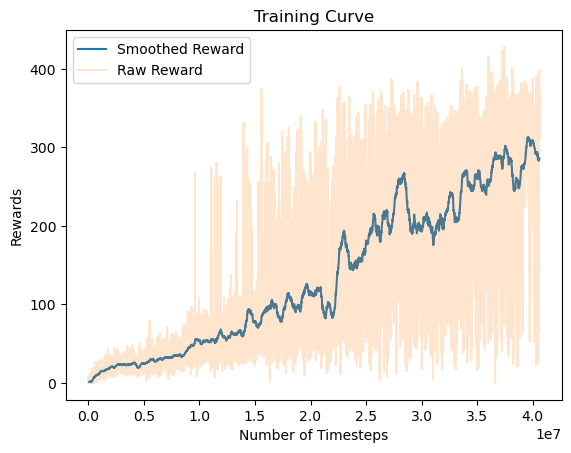

In [17]:
def plot_results(log_folder: str):
    """
    Plots the training curve from the Monitor log file.
    :param log_folder: the save directory of the Monitor logs
    """
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    
    # Smooth the curve
    y_smooth = np.convolve(y, np.ones(100)/100, mode='valid')
    x_smooth = x[len(x) - len(y_smooth):]

    fig = plt.figure("Training Curve")
    plt.plot(x_smooth, y_smooth, label="Smoothed Reward")
    plt.plot(x, y, alpha=0.2, label="Raw Reward")
    plt.xlabel("Number of Timesteps")
    plt.ylabel("Rewards")
    plt.title("Training Curve")
    plt.legend()
    plt.show()

# Call the function after training to see the learning curve
plot_results(log_dir)

## Video Recording and Display Functions

In [18]:
# Functions to record and show videos of the agent playing

def show_videos(video_path="", prefix=""):
    html = []
    for mp4 in Path(video_path).glob(f"{prefix}*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append(
            f'''<video alt="{mp4.name}" autoplay loop controls style="height: 400px;">
                  <source src="data:video/mp4;base64,{video_b64.decode('ascii')}" type="video/mp4" />
             </video>'''
        )
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

# ### MODIFICATION ###: Updated video folder and env_id
def record_video(env_id, model, video_length=500, prefix="", video_folder="ppo/videos"):
    os.makedirs(video_folder, exist_ok=True)
    eval_env = make_atari_env(env_id, n_envs=1, seed=0, vec_env_cls=DummyVecEnv)
    eval_env = VecFrameStack(eval_env, n_stack=4)
    eval_env = VecVideoRecorder(
        eval_env,
        video_folder=video_folder,
        record_video_trigger=lambda step: step == 0,
        video_length=video_length,
        name_prefix=prefix,
    )
    obs = eval_env.reset()
    for _ in range(video_length):
        action, _ = model.predict(obs, deterministic=True) # Use deterministic for evaluation
        obs, _, _, _ = eval_env.step(action)
    eval_env.close()

## Record and Display Videos at Different Training Stages

In [21]:
# Functions for analyzing the trained models

# Function to get the identifiers of saved models
def get_model_identifiers(models_dir):
    files = os.listdir(models_dir)  # Listing files in the models directory
    model_files = [f for f in files if f.startswith('model_')]  # Filtering out model files
    identifiers = [f.split('_')[1] for f in model_files]  # Extracting identifiers from file names
    return identifiers

# Function to find key identifiers (earliest, middle, final)
def find_key_identifiers(identifiers):
    identifiers.sort()  # Sorting identifiers
    earliest = identifiers[0]  # Earliest identifier
    final = identifiers[-1]  # Final identifier
    middle = identifiers[len(identifiers) // 2]  # Middle identifier
    return earliest, middle, final

# Function to view videos of the models at different training stages
def view(models_dir):
    identifiers = get_model_identifiers(models_dir)  # Getting model identifiers
    print(identifiers)
    earliest, middle, final = find_key_identifiers(identifiers)  # Finding key identifiers

    # Recording and displaying videos at the beginning, middle, and end of training
    for stage, identifier in zip(["beginning", "middle", "end"], [earliest, middle, final]):
        model_path = os.path.join(models_dir, f'model_{identifier}')  # Forming the model path
        model = PPO.load(model_path)  # Loading the model
        record_video("BreakoutNoFrameskip-v4", model, video_length=5000, prefix=f'ppo-breakout-{stage}')  # Recording video
        show_videos("ppo/videos/", prefix=f'ppo-breakout-{stage}')  # Showing videos

In [22]:
# Changes the model directory below
models_directory="ppo/models"
view(models_directory)  # Calling the view function

['100000.zip', '200000.zip', '300000.zip', '400000.zip', '500000.zip', '600000.zip', '700000.zip', '800000.zip', '900000.zip', '1000000.zip', '1100000.zip', '1200000.zip', '1300000.zip', '1400000.zip', '1500000.zip', '1600000.zip', '1700000.zip', '1800000.zip', '1900000.zip', '2000000.zip', '2100000.zip', '2200000.zip', '2300000.zip', '2400000.zip', '2500000.zip', '2600000.zip', '2700000.zip', '2800000.zip', '2900000.zip', '3000000.zip', '3100000.zip', '3200000.zip', '3300000.zip', '3400000.zip', '3500000.zip', '3600000.zip', '3700000.zip', '3800000.zip', '3900000.zip', '4000000.zip', '4100000.zip', '4200000.zip', '4300000.zip', '4400000.zip', '4500000.zip', '4600000.zip', '4700000.zip', '4800000.zip', '4900000.zip', '5000000.zip', '5100000.zip', '5200000.zip', '5300000.zip', '5400000.zip', '5500000.zip', '5600000.zip', '5700000.zip', '5800000.zip', '5900000.zip', '6000000.zip', '6100000.zip', '6200000.zip', '6300000.zip', '6400000.zip', '6500000.zip', '6600000.zip', '6700000.zip', '68

MoviePy - Done !
MoviePy - video ready /home/sagemaker-user/RLA2/breakout/ppo/videos/ppo-breakout-beginning-step-0-to-step-5000.mp4


Saving video to /home/sagemaker-user/RLA2/breakout/ppo/videos/ppo-breakout-middle-step-0-to-step-5000.mp4
MoviePy - Building video /home/sagemaker-user/RLA2/breakout/ppo/videos/ppo-breakout-middle-step-0-to-step-5000.mp4.
MoviePy - Writing video /home/sagemaker-user/RLA2/breakout/ppo/videos/ppo-breakout-middle-step-0-to-step-5000.mp4



MoviePy - Done !
MoviePy - video ready /home/sagemaker-user/RLA2/breakout/ppo/videos/ppo-breakout-middle-step-0-to-step-5000.mp4


Saving video to /home/sagemaker-user/RLA2/breakout/ppo/videos/ppo-breakout-end-step-0-to-step-5000.mp4
MoviePy - Building video /home/sagemaker-user/RLA2/breakout/ppo/videos/ppo-breakout-end-step-0-to-step-5000.mp4.
MoviePy - Writing video /home/sagemaker-user/RLA2/breakout/ppo/videos/ppo-breakout-end-step-0-to-step-5000.mp4



MoviePy - Done !
MoviePy - video ready /home/sagemaker-user/RLA2/breakout/ppo/videos/ppo-breakout-end-step-0-to-step-5000.mp4
